## Comparing observed and unobserved fishing characteristics in the drift gillnet fishery for swordfish: Effort Model Selection

Version: 10<br>
Date: updated 06/16/2022

Objective: Provide the Python code of the classification models used to identify fishing vs non-fishing records from the VMS, as well as the metric outputs. 

Models included were (1) naïve Bayes, (2) support-vector machine, (3) decision tree, (4) random forest, and (5) gradient boosting

In [50]:
# library packages for part one of the analysis
import cx_Oracle, getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
pd.options.display.max_columns = None

In [2]:
user = "xxxx"
host = "xxxx"
port = "xxxx"
sid = "xxxx"
pswd = 'xxxx'
dsn = cx_Oracle.makedsn (host, port, sid)

connection  = cx_Oracle.connect (user, pswd, dsn)

In [3]:
# database view of VMS and supplemental data for this project
sql = "SELECT * FROM VMS.DGN_VMS_ML_V" 
vms = pd.read_sql(sql, con=connection)

## <font color="blue">Feature Engineering and Selection</font>

In [4]:
vms.loc[:, "TRACK_LONGITUDE"] = pd.to_numeric(vms.loc[:, "TRACK_LONGITUDE"], errors='coerce')
HasNan = np.isnan(vms.loc[:,"TRACK_LONGITUDE"]) 
vms.loc[HasNan, "TRACK_LONGITUDE"] = np.nanmedian(vms.loc[:, "TRACK_LONGITUDE"])
#min/max normalization
vms.loc[:, "TRACK_LONGITUDE"] =(vms.loc[:, "TRACK_LONGITUDE"] - min(vms.loc[:, "TRACK_LONGITUDE"]))/(max(vms.loc[:, "TRACK_LONGITUDE"]) - min(vms.loc[:, "TRACK_LONGITUDE"]))


vms.loc[:, "TRACK_LATITUDE"] = pd.to_numeric(vms.loc[:, "TRACK_LATITUDE"], errors='coerce')
HasNan = np.isnan(vms.loc[:,"TRACK_LATITUDE"]) 
vms.loc[HasNan, "TRACK_LATITUDE"] = np.nanmedian(vms.loc[:, "TRACK_LATITUDE"])
#min/max normalization
vms.loc[:, "TRACK_LATITUDE"] =(vms.loc[:, "TRACK_LATITUDE"] - min(vms.loc[:, "TRACK_LATITUDE"]))/(max(vms.loc[:, "TRACK_LATITUDE"]) - min(vms.loc[:, "TRACK_LATITUDE"]))

### Engineered Speed Features
The below scaling the speed features that were engineered in SQL similar to the approach document by Jordan Watson's approach.

In [5]:
#min/max normalization of the data
vms.loc[:, "METERS_PER_MINUTE"] =(vms.loc[:, "METERS_PER_MINUTE"] - min(vms.loc[:, "METERS_PER_MINUTE"]))/(max(vms.loc[:, "METERS_PER_MINUTE"]) - min(vms.loc[:, "METERS_PER_MINUTE"]))
vms.loc[:, "SPEED_TNEG1"] =(vms.loc[:, "SPEED_TNEG1"] - min(vms.loc[:, "SPEED_TNEG1"]))/(max(vms.loc[:, "SPEED_TNEG1"]) - min(vms.loc[:, "SPEED_TNEG1"]))
vms.loc[:, "SPEED_TPLUS1"] =(vms.loc[:, "SPEED_TPLUS1"] - min(vms.loc[:, "SPEED_TPLUS1"]))/(max(vms.loc[:, "SPEED_TPLUS1"]) - min(vms.loc[:, "SPEED_TPLUS1"]))
vms.loc[:, "SPEED_T5"] =(vms.loc[:, "SPEED_T5"] - min(vms.loc[:, "SPEED_T5"]))/(max(vms.loc[:, "SPEED_T5"]) - min(vms.loc[:, "SPEED_T5"]))
vms.loc[:, "SPEED_AVG"] =(vms.loc[:, "SPEED_AVG"] - min(vms.loc[:, "SPEED_AVG"]))/(max(vms.loc[:, "SPEED_AVG"]) - min(vms.loc[:, "SPEED_AVG"]))

### Engineered Distance Features
The below scaling the distance features that were engineered in SQL similar to the approach document by Jordan Watson's approach. 

In [6]:
#min/max normalization of the data
vms.loc[:, "AVG_DISTANCE"] =(vms.loc[:, "AVG_DISTANCE"] - min(vms.loc[:, "AVG_DISTANCE"]))/(max(vms.loc[:, "AVG_DISTANCE"]) - min(vms.loc[:, "AVG_DISTANCE"]))
vms.loc[:, "DISTANCE_TNEG1"] =(vms.loc[:, "DISTANCE_TNEG1"] - min(vms.loc[:, "DISTANCE_TNEG1"]))/(max(vms.loc[:, "DISTANCE_TNEG1"]) - min(vms.loc[:, "DISTANCE_TNEG1"]))
vms.loc[:, "DISTANCE_TPLUS1"] =(vms.loc[:, "DISTANCE_TPLUS1"] - min(vms.loc[:, "DISTANCE_TPLUS1"]))/(max(vms.loc[:, "DISTANCE_TPLUS1"]) - min(vms.loc[:, "DISTANCE_TPLUS1"]))
vms.loc[:, "DISTANCE_T5"] =(vms.loc[:, "DISTANCE_T5"] - min(vms.loc[:, "DISTANCE_T5"]))/(max(vms.loc[:, "DISTANCE_T5"]) - min(vms.loc[:, "DISTANCE_T5"]))
vms.loc[:, "DISTANCE_METERS"] =(vms.loc[:, "DISTANCE_METERS"] - min(vms.loc[:, "DISTANCE_METERS"]))/(max(vms.loc[:, "DISTANCE_METERS"]) - min(vms.loc[:, "DISTANCE_METERS"]))

### Vessel Characteristics
Next cell scales the corresponding vessel characteristics obtained from USCG and state agencies.

In [7]:
#min/max normalization of vessel characteristics 
vms.loc[:, "NTONS"] =(vms.loc[:, "NTONS"] - min(vms.loc[:, "NTONS"]))/(max(vms.loc[:, "NTONS"]) - min(vms.loc[:, "NTONS"]))
#min/max normalization
#vms.loc[:, "HPOWER"] =(vms.loc[:, "HPOWER"] - min(vms.loc[:, "HPOWER"]))/(max(vms.loc[:, "HPOWER"]) - min(vms.loc[:, "HPOWER"]))
#min/max normalization
vms.loc[:, "LENGTH"] =(vms.loc[:, "LENGTH"] - min(vms.loc[:, "LENGTH"]))/(max(vms.loc[:, "LENGTH"]) - min(vms.loc[:, "LENGTH"]))

### Daily Sea Surface Temperature
The imputation and scaling the SSP variable 

In [8]:
# filling in NA for temp values using nearest neighbor function
vms.loc[:, "DAILY_TEMPERATURE"] = vms.loc[:, "DAILY_TEMPERATURE"].fillna(method='ffill')
vms.loc[:, "DAILY_TEMPERATURE"] =(vms.loc[:, "DAILY_TEMPERATURE"] - min(vms.loc[:, "DAILY_TEMPERATURE"]))/(max(vms.loc[:, "DAILY_TEMPERATURE"]) - min(vms.loc[:, "DAILY_TEMPERATURE"]))

### GIS Attributes
The scaling the GIS features

In [9]:
#min/max normalization of the data
vms.loc[:, "DEPTH_GIS"] =(vms.loc[:, "DEPTH_GIS"] - min(vms.loc[:, "DEPTH_GIS"]))/(max(vms.loc[:, "DEPTH_GIS"]) - min(vms.loc[:, "DEPTH_GIS"]))
vms.loc[:, "DIST_FROM_SHORE"] =(vms.loc[:, "DIST_FROM_SHORE"] - min(vms.loc[:, "DIST_FROM_SHORE"]))/(max(vms.loc[:, "DIST_FROM_SHORE"]) - min(vms.loc[:, "DIST_FROM_SHORE"]))

## <font color="blue">Data Models to Identify Fishing</font>

In [10]:
# pulling out all VMS data with corresponding observer data. These data will be used to train the models
vms_obs = vms.loc[(vms.loc[:, 'IS_OBSERVED_TRIP'] == 1) & (vms.loc[:, 'VESSEL_TYPE'] == 'OBS') & (vms.loc[:, 'TRIP_NUM'] != 1295),  :]
#vms_obs = vms_obs.reset_index(drop=True)

In [11]:
vms_eval = vms_obs[["TRACK_LONGITUDE", "TRACK_LATITUDE", "NTONS", "LENGTH", "DISTANCE_METERS", "DISTANCE_TNEG1", "DISTANCE_TPLUS1", "DISTANCE_T5", "AVG_DISTANCE",
         "METERS_PER_MINUTE", "SPEED_TNEG1", "SPEED_TPLUS1","SPEED_T5", "SPEED_AVG", "IS_FISHING_SQL", "DEPTH_GIS", "DIST_FROM_SHORE", 
         "DAILY_TEMPERATURE","IS_OBSERVED",]]

In [12]:
num_cols = list(vms_eval.columns)

In [13]:
# calc. correlation
vms_eval_corr = vms_eval.loc[:, num_cols].corr()

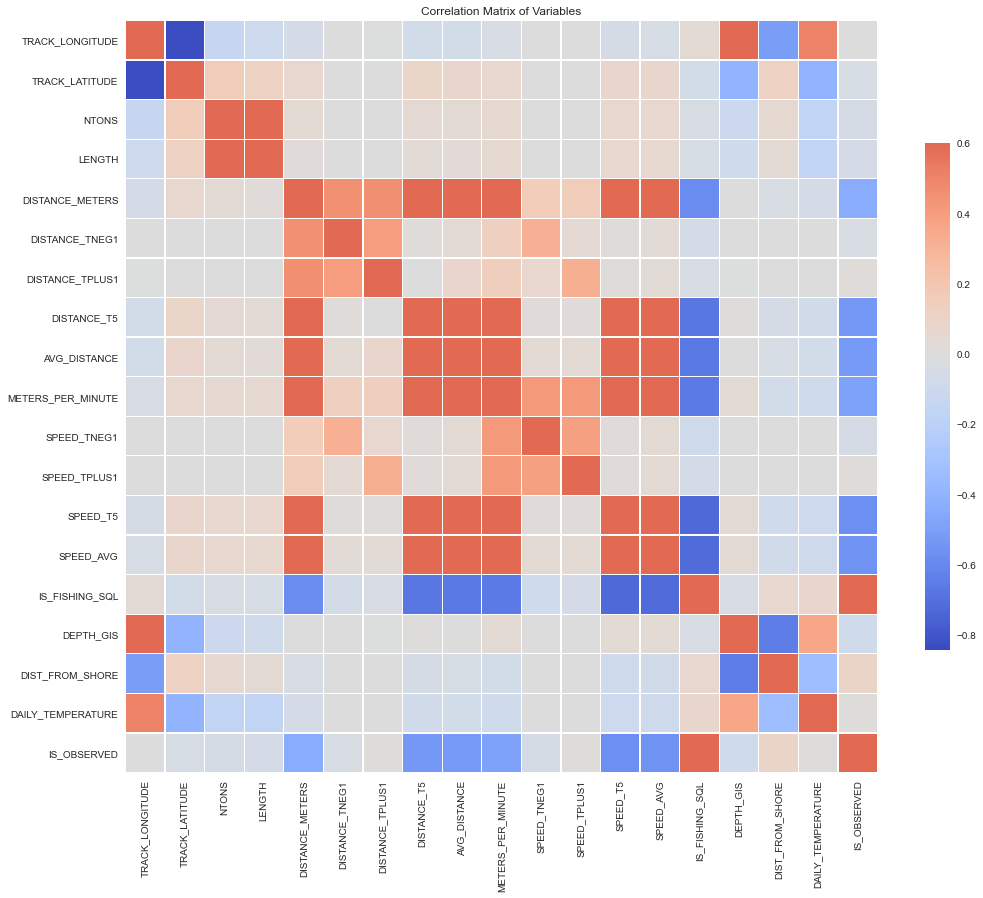

In [14]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(vms_eval_corr, vmax=0.6, center=0, cmap='coolwarm', fmt=".9f",
            square=True, linewidths=.25, cbar_kws={"shrink": .5})
#ax = plt.figure(figsize=(25, 10)).gca()
plt.title('Correlation Matrix of Variables')
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.tight_layout()
#plt.savefig('DGN_CorrelationMatrix.png')

In [15]:
# Selecting attributes for RFM and other

#X = vms_obs[["DISTANCE_METERS", "DISTANCE_T5", "AVG_DISTANCE", "METERS_PER_MINUTE", "SPEED_T5", "SPEED_AVG", "IS_OBSERVED", "DEPTH_GIS", "DIST_FROM_SHORE",
#             "DAILY_TEMPERATURE", "DEPTH_GIS", "IS_FISHING_SQL"]]

X = vms_obs[["TRACK_LONGITUDE", "TRACK_LATITUDE", "NTONS", "LENGTH", "DISTANCE_METERS", "DISTANCE_TNEG1", "DISTANCE_TPLUS1", "DISTANCE_T5", "AVG_DISTANCE",
         "METERS_PER_MINUTE", "SPEED_TNEG1", "SPEED_TPLUS1","SPEED_T5", "SPEED_AVG", "IS_OBSERVED", "DEPTH_GIS", "DIST_FROM_SHORE", 
         "DAILY_TEMPERATURE", "IS_FISHING_SQL"]]

y = X.pop("IS_OBSERVED")

In [16]:
# Spliting attributes into train and test datasets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [17]:
print(y_train.count())
print(y_test.count())

14342
4781


### Naive Bayes Classification Model

In [18]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes classifier
nbc = GaussianNB() 
nbc.fit(x_train, y_train)

y_pred_nb = nbc.predict(x_test)

probas_nb = nbc.predict_proba(x_test)

In [19]:
# Confusion Matrix
# CM = confusion_matrix(y_test, y_pred_nb)
# print ("\n\nTable 2. Naive Bayes Classifier\n Confusion matrix:\n", CM)
# tn, fp, fn, tp = CM.ravel()
# print ("\nTP, TN, FP, FN:", tp, ",", tn, ",", fp, ",", fn)
AR = accuracy_score(y_test, y_pred_nb)
print ("\nNaive Bayes Accuracy rate:", np.round(AR, 2))
ER = 1.0 - AR
print ("\nNaive Bayes Error rate:", np.round(ER, 2))
P = precision_score(y_test, y_pred_nb)
print ("\nNaive Bayes Precision:", np.round(P, 2))
R = recall_score(y_test, y_pred_nb)
print ("\nNaive Bayes Recall:", np.round(R, 2))
F1 = f1_score(y_test, y_pred_nb)
print ("\nNaive Bayes F1 score:", np.round(F1, 2))


Naive Bayes Accuracy rate: 0.82

Naive Bayes Error rate: 0.18

Naive Bayes Precision: 0.72

Naive Bayes Recall: 0.95

Naive Bayes F1 score: 0.82


### Support Vector Machine Classification Model

In [51]:
from sklearn.svm import SVC

svc_clf = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
svc_clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
y_pred_svc = svc_clf.predict(x_test)

# svm probs
probas_svc = svc_clf.predict_proba(x_test)

In [23]:
# Confusion Matrix
AR = accuracy_score(y_test, y_pred_svc)
print ("\nSupport Vector Machine Accuracy rate:", np.round(AR, 2))
ER = 1.0 - AR
print ("\nSupport Vector Machine Error rate:", np.round(ER, 2))
P = precision_score(y_test, y_pred_svc)
print ("\nSupport Vector Machine Precision:", np.round(P, 2))
R = recall_score(y_test, y_pred_svc)
print ("\nSupport Vector Machine Recall:", np.round(R, 2))
F1 = f1_score(y_test, y_pred_svc)
print ("\nSupport Vector Machine F1 score:", np.round(F1, 2))


Support Vector Machine Accuracy rate: 0.86

Support Vector Machine Error rate: 0.14

Support Vector Machine Precision: 0.77

Support Vector Machine Recall: 0.96

Support Vector Machine F1 score: 0.85


### Decision Tree Classifcation Model

In [24]:
from sklearn.tree import DecisionTreeClassifier 

# decision tree classifier with some tuned hyperparameters
dtc = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=18,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

In [53]:
#fit model to training data
dtc.fit(x_train, y_train)

# model prediction on test data
y_pred_dtc = dtc.predict(x_test)

probas_dtc = dtc.predict_proba(x_test)

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


In [26]:
# Confusion Matrix
AR = accuracy_score(y_test, y_pred_dtc)
print ("\nDecision Tree Classifier Accuracy rate:", np.round(AR, 2))
ER = 1.0 - AR
print ("\nDecision Tree Classifier Error rate:", np.round(ER, 2))
P = precision_score(y_test, y_pred_dtc)
print ("\nDecision Tree Classifier Precision:", np.round(P, 2))
R = recall_score(y_test, y_pred_dtc)
print ("\nDecision Tree Classifier Recall:", np.round(R, 2))
F1 = f1_score(y_test, y_pred_dtc)
print ("\nDecision Tree Classifier F1 score:", np.round(F1, 2))


Decision Tree Classifier Accuracy rate: 0.88

Decision Tree Classifier Error rate: 0.12

Decision Tree Classifier Precision: 0.8

Decision Tree Classifier Recall: 0.97

Decision Tree Classifier F1 score: 0.87


### Random Forest Classifier Best Hyper-parameters

In [27]:
# This code provided a randomized search for the best hyperparameters, which allowed for a more refined search of the best 
# hyperparameters using the gridsearchCV below. These searches are commented out b/c they take a lot of time to run. 

# from sklearn.model_selection import RandomizedSearchCV
# #Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 20)]
# #Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# #Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# #Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# #Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# #Method of selecting samples for training each tree
# bootstrap = [True, False]
# #Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [28]:
#from sklearn.ensemble import RandomForestClassifier 

# rfm_clf = RandomForestClassifier()

In [29]:
# randm = RandomizedSearchCV(estimator=rfm_clf, param_distributions = random_grid, 
#                            cv = 5, n_iter = 10, n_jobs=-1)
# randm.fit(x_train, y_train)

In [30]:
# print (randm.best_score_)
# print (randm.best_params_)
# print (randm.best_estimator_)

### Gradient Boosting Classifier Best Hyper-parameters

In [31]:
# # The best gradient boosting classifier hyperparameters from the gridsearch with cross-fold validation.
# from sklearn.ensemble import GradientBoostingClassifier
# from scipy.stats import uniform as sp_randFloat
# from scipy.stats import randint as sp_randInt 

# gbm_clf = GradientBoostingClassifier()

In [32]:
# from sklearn.model_selection import RandomizedSearchCV

# parameters = {'learning_rate': sp_randFloat(),
#               'subsample'    : sp_randFloat(),
#               'n_estimators' : sp_randInt(100, 1000),
#               'max_depth'    : sp_randInt(2, 10),
#               'min_samples_split' : sp_randInt(2, 100),
#               'min_samples_leaf'  : sp_randInt(1, 10),
#              }

# randgbc = RandomizedSearchCV(estimator=gbm_clf, param_distributions = parameters, 
#                            cv = 5, n_iter = 10, n_jobs=-1)
# randgbc.fit(x_train, y_train)

In [33]:
# print (randgbc.best_score_)
# print (randgbc.best_params_)
# print (randgbc.best_estimator_)

### Random Forest Classification Model

In [34]:
# The best hyperparameters came from the above gridsearch with cross-fold validation.
from sklearn.ensemble import RandomForestClassifier 

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1266, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
#fit model to training data
clf.fit(x_train, y_train)

# model prediction on test data
y_pred = clf.predict(x_test)

probas = clf.predict_proba(x_test)

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precis

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

In [36]:
# Confusion Matrix
AR = accuracy_score(y_test, y_pred)
print ("\nRandom Forest Classifier Accuracy rate:", np.round(AR, 2))
ER = 1.0 - AR
print ("\nRandom Forest Classifier Error rate:", np.round(ER, 2))
P = precision_score(y_test, y_pred)
print ("\nRandom Forest Classifier Precision:", np.round(P, 2))
R = recall_score(y_test, y_pred)
print ("\nRandom Forest Classifier Recall:", np.round(R, 2))
F1 = f1_score(y_test, y_pred)
print ("\nRandom Forest Classifier F1 score:", np.round(F1, 2))


Random Forest Classifier Accuracy rate: 0.9

Random Forest Classifier Error rate: 0.1

Random Forest Classifier Precision: 0.85

Random Forest Classifier Recall: 0.93

Random Forest Classifier F1 score: 0.89


<Figure size 576x396 with 0 Axes>

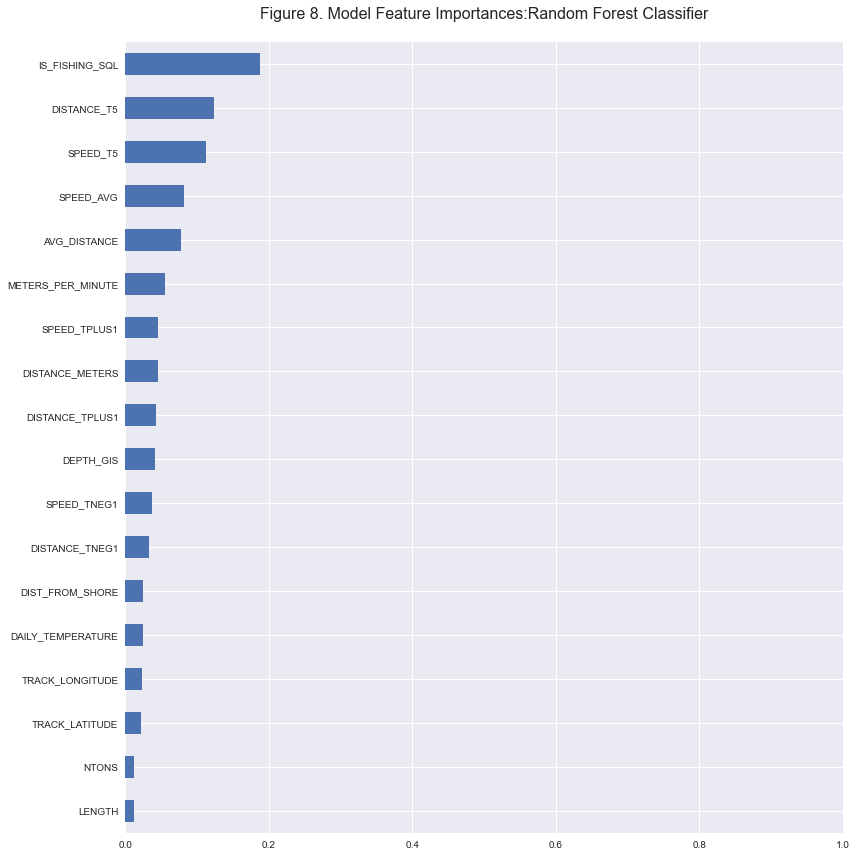

In [37]:
plt.style.use('seaborn')
plt.figure()
fig = plt.figure(figsize=(12,12)) # define plot area
ax = fig.gca() # define axis
ax.set_xlim([0,1.0])
plt.title('Figure 8. Model Feature Importances:Random Forest Classifier\n', fontsize=16)
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(12,12))
plt.tight_layout()

### Gradient Boosting Classification Model

In [55]:
# The best gradient boosting classifier hyperparameters from the gridsearch with cross-fold validation.
from sklearn.ensemble import GradientBoostingClassifier

gbm_clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.32660942480008437, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=9, min_samples_split=91,
              min_weight_fraction_leaf=0.0, n_estimators=452,
              n_iter_no_change=None, random_state=None,
              subsample=0.8967175414256934, tol=0.0001,
              validation_fraction=0.1, presort='auto', verbose=0, warm_start=False) 

In [56]:
#fit model to training data
gbm_clf.fit(x_train, y_train)

# model prediction on test data
y_pred_gbm = gbm_clf.predict(x_test)

probas_gbm = gbm_clf.predict_proba(x_test)

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1302: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.object)
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1489: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_mask = np.ones((n_samples, ), dtype=np.bool)
C:\Users\rames\AppData\Roaming\Python\Pytho

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\gradient_boosting.py:1162: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sampl

In [57]:
# Confusion Matrix
AR = accuracy_score(y_test, y_pred_gbm)
print ("\nGradient Boosting Classifier Accuracy rate:", np.round(AR, 2))
ER = 1.0 - AR
print ("\nGradient Boosting Classifier Error rate:", np.round(ER, 2))
P = precision_score(y_test, y_pred_gbm)
print ("\nGradient Boosting Classifier Precision:", np.round(P, 2))
R = recall_score(y_test, y_pred_gbm)
print ("\nGradient Boosting Classifier Recall:", np.round(R, 2))
F1 = f1_score(y_test, y_pred_gbm)
print ("\nGradient Boosting Classifier F1 score:", np.round(F1, 2))


Gradient Boosting Classifier Accuracy rate: 0.91

Gradient Boosting Classifier Error rate: 0.09

Gradient Boosting Classifier Precision: 0.87

Gradient Boosting Classifier Recall: 0.91

Gradient Boosting Classifier F1 score: 0.89


In [58]:
# ROC analysis
LW_r = 1.5 # line width for plots
LL_r = "lower right" # legend location
LC_r = 'darkgreen' # Line Color

fpr_r, tpr_r, th_r = roc_curve(y_test, probas[:,1]) # False Positive Rate, True Posisive Rate, probability thresholds
AUC = auc(fpr_r, tpr_r)

# ROC analysis
LW_g = 1.5 # line width for plots
LL_g = "lower right" # legend location
LC_g = 'darkblue' # Line Color

fpr_g, tpr_g, th_g = roc_curve(y_test, probas_gbm[:,1]) # False Positive Rate, True Posisive Rate, probability thresholds
AUC = auc(fpr_g, tpr_g)

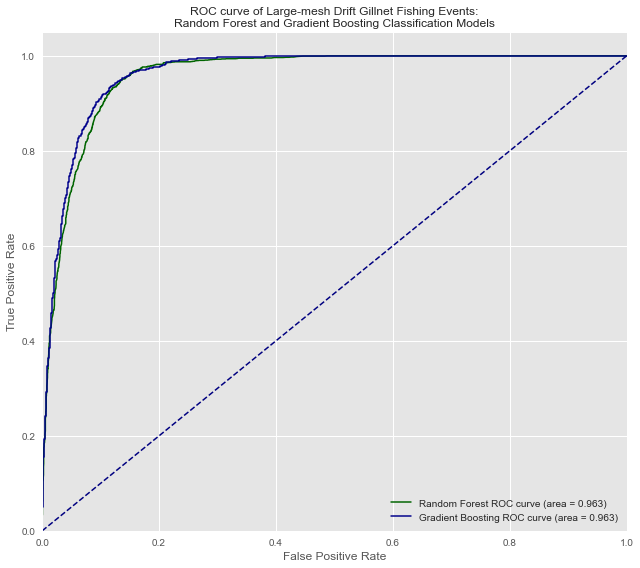

In [59]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(9, 8)).gca()
#plt.figure()
#fig = plt.figure(figsize=(6,6)) # define plot area
#ax = fig.gca() # define axis
plt.title('ROC curve of Large-mesh Drift Gillnet Fishing Events:\nRandom Forest and Gradient Boosting Classification Models', fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_r, tpr_r, color=LC_r,lw=LW_r, label='Random Forest ROC curve (area = %0.3f)' % AUC)
plt.plot(fpr_g, tpr_g, color=LC_g,lw=LW_g, label='Gradient Boosting ROC curve (area = %0.3f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=LW_r, linestyle='--') # reference line for random classifier
plt.legend(loc=LL_r) 
plt.tight_layout()

In [43]:
X_all = vms[["TRACK_LONGITUDE", "TRACK_LATITUDE", "NTONS", "LENGTH", "DISTANCE_METERS", "DISTANCE_TNEG1", "DISTANCE_TPLUS1", "DISTANCE_T5", "AVG_DISTANCE",
         "METERS_PER_MINUTE", "SPEED_TNEG1", "SPEED_TPLUS1","SPEED_T5", "SPEED_AVG", "DEPTH_GIS", "DIST_FROM_SHORE", 
         "DAILY_TEMPERATURE", "IS_FISHING_SQL"]]

In [44]:
# Random forest Fishing predictions
y_pred_clf = clf.predict(X_all)

# Gradient Boosting Fishing predictions
y_pred_gbm_clf = gbm_clf.predict(X_all)

C:\Users\rames\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [45]:
# attaching the predicted fishing from the Random forest and gradient boosting models back to original VMS data set
vms["RFC_PREDICT"] = y_pred_clf 
vms["GBC_PREDICT"] = y_pred_gbm_clf 

In [46]:
model_upload = vms.loc[:,["ID", "RFC_PREDICT", "GBC_PREDICT"]]

In [47]:
model_upload["ID"] = model_upload.loc[:, "ID"].astype(int)
model_upload["RFC_PREDICT"] = model_upload.loc[:, "RFC_PREDICT"].astype(float)
model_upload["GBC_PREDICT"] = model_upload.loc[:, "GBC_PREDICT"].astype(float)

In [48]:
model_upload.head()

,ID,RFC_PREDICT,GBC_PREDICT
0,210155216,0.0,0.0
1,210156033,0.0,0.0
2,210159467,0.0,0.0
3,210162782,0.0,0.0
4,210166075,0.0,0.0


In [ ]:
#import cx_Oracle
ORACLE_CONNECT = "vms/PW@(DESCRIPTION=(SOURCE_ROUTE=OFF)(ADDRESS_LIST=(ADDRESS=(PROTOCOL=TCP)(HOST=XXXX)(PORT=XXXX)))(CONNECT_DATA=(SID=XXXX)(SRVR=DEDICATED)))"

con = cx_Oracle.connect(ORACLE_CONNECT)

In [ ]:
rows = [tuple(x) for x in model_upload.values]

In [ ]:
cur = con.cursor()
cur.executemany("INSERT INTO DGN_VMS_FISH_PREDICT2(ID, RFM_PREDICT, GBM_PREDICT) values (:1, :2, :3)", rows)
con.commit()

In [ ]:
# making new data set with predictions and ID to join to Oracle Table in database
vms_all_upload = vms.loc[:,["ID", "rfc_predict", "gbc_predict"]]

export data with predictions to be loaded back to the PacFIN DB
vms_all_upload.to_csv("DGN_Predict_upload", sep=',')